# Creating WTs with IMP

This notebook contains code for:
- importing necessary libraries
- dowloading and preprocessing the dataset
- using the dataset to train the full model and save the accuracies
- performing IMP (with rewinding) using the model and datset
- comparing pruned and unpruned model accuracies
- saving sparse model weights of WTs in Folder

In [1]:
# importing necessary libraries and the cnn architecture I defined

from cnn_architecture import CNN2Model
from utils import *
from load_datasets import load_and_prep_dataset

import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.io import loadmat
import copy

2024-05-25 09:23:18.176699: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# shape of the model weights

train_dataset, test_dataset = load_and_prep_dataset("CIFAR", batch_size=60, shuffle_size=512)
model = CNN2Model()
model(list(train_dataset)[0][0])

weights = model.get_weights()
biases = weights[1::2]
not_biases = weights[0::2]

for w in weights:
    print(w.shape)

2024-05-25 09:23:22.343894: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2024-05-25 09:23:22.544192: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [1]
	 [[{{node Placeholder/_2}}]]
2024-05-25 09:23:22.544627: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [1]
	 [[{{node Placeholder/_2}}]]


(3, 3, 3, 64)
(64,)
(3, 3, 64, 64)
(64,)
(16384, 256)
(256,)
(256, 256)
(256,)
(256, 10)
(10,)


### Train Loop and IMP loop

In [3]:
# modified train loop to also work with sparse networks (such that pruned weights remain frozen at 0.0)

def train_loop_sparse(train, test, model, num_epochs=5):
    
    # hyperparameters
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002)
    loss_function= tf.keras.losses.CategoricalCrossentropy()
    
    # initializing training statistics
    train_accuracy = tf.keras.metrics.Accuracy(name='test_accuracy')
    test_accuracy = tf.keras.metrics.Accuracy(name='train_accuracy')
    train_losses = tf.keras.metrics.CategoricalCrossentropy(name='train_losses')
    test_losses = tf.keras.metrics.CategoricalCrossentropy(name='test_losses')
    train_acc = []
    test_acc = []
    train_l =[]
    test_l = []

    for epoch in tqdm(range(num_epochs), leave=False, desc="training epochs"):
        
        #train step
        for x, t in train:
            with tf.GradientTape() as tape:
                pred = model(x)
                loss = loss_function(t, pred)
                train_losses.update_state(t, pred)
                train_accuracy.update_state(tf.argmax(t,1), tf.argmax(pred,1))
            gradients = tape.gradient(loss, model.trainable_variables)
            
            # set gradients to zero for all pruned weights
            new_gradients = []
            for gradient_matrix, variables in zip(gradients, model.trainable_variables):
                gradient_matrix = tf.where(variables == 0.0, 0.0, gradient_matrix)
                new_gradients.append(gradient_matrix)
            optimizer.apply_gradients(zip(new_gradients, model.trainable_variables))
            
        # test step
        for x, t in test:
            pred = model(x)
            test_accuracy.update_state(tf.argmax(t,1), tf.argmax(pred,1))
            test_losses.update_state(t, pred)
        
        # updataing training statistics
        train_acc.append(train_accuracy.result().numpy())
        test_acc.append(test_accuracy.result().numpy())
        train_l.append(train_losses.result().numpy())
        test_l.append(test_losses.result().numpy())
        train_accuracy.reset_state()
        test_accuracy.reset_state()
        train_losses.reset_state()
        test_losses.reset_state()
        
    # collecting losses in a dictionary
    losses = { "test loss":test_l , "training loss":train_l , "test accuracy":test_acc , "training accuracy":train_acc}
    
    return  losses

In [4]:
# iterative magnitude pruning

def imp(datasetname, train, test, model, run, iterations=10, epochs_per_it=5, pruning_rate_conv=15, pruning_rate_dense=30, save_in_between=True):
    
    # safe initial weights
    initial_weights = model.get_weights()
    
    # initializing training statistics
    losses = { "test loss":[] , "training loss":[], "test accuracy":[] , "training accuracy":[]}
    pruning_rates = [get_pruning_rates(initial_weights[::2])]   
    
    # iterations
    for i in tqdm(range(iterations), position=0, desc="pruning iterations"):
        
        
        ##################################################
        # Training #######################################
        ##################################################

        new_losses = train_loop_sparse(train, test, model, num_epochs=epochs_per_it)
        losses["training accuracy"].extend(new_losses["training accuracy"])
        losses["test accuracy"].extend(new_losses["test accuracy"])
        losses["training loss"].extend(new_losses["training loss"])
        losses["test loss"].extend(new_losses["test loss"])     
        
        ##################################################
        # Pruning ########################################  
        ##################################################
        

        new_weights = copy.copy(initial_weights)
        
        # prune conv layers layer-wise:
        new_conv_weights = []   
        for conv_current, conv_init in zip(model.get_weights()[0:4:2], initial_weights[0:4:2]):
            
            # calculate percentile
            conv_current_flat = conv_current.flatten()
            conv_unpruned = copy.copy(conv_current_flat[conv_current_flat != 0.0])
            conv_unpruned_abs =  tf.math.abs(conv_unpruned)
            conv_percentile = np.percentile(conv_unpruned_abs, pruning_rate_conv)
            
            # prune according to percentile
            conv_current_pruned = tf.where(tf.math.abs(conv_current) < conv_percentile, 0.0, conv_init)
            new_conv_weights.append(conv_current_pruned)
        
        # replace the unpruned conv layers by the pruned conv layers
        new_weights[0] = new_conv_weights[0] 
        new_weights[2] = new_conv_weights[1]      
        
        #---------
        
        # calculate percentile of dense layer globally
        dense_unpruned_abs_all = []
        for dense_layer in model.get_weights()[4::2]:
            dense_flat = dense_layer.flatten()
            dense_unpruned = copy.copy(dense_flat[dense_flat != 0.0])
            dense_unpruned_abs =  tf.math.abs(dense_unpruned)
            dense_unpruned_abs_all.extend(dense_unpruned_abs)
        dense_percentile = np.percentile(dense_unpruned_abs_all, pruning_rate_dense)
        
        # prune dense layers according to percentile
        new_dense_weights = []
        for dense_current, dense_init in zip(model.get_weights()[4::2], initial_weights[4::2]):
            
            dense_pruned = tf.where(tf.math.abs(dense_current) < dense_percentile, 0.0, dense_init)
            new_dense_weights.append(dense_pruned)
        
        # replace the unpruned dense layers by the pruned dense layers
        new_weights[4] = new_dense_weights[0] 
        new_weights[6] = new_dense_weights[1]
        new_weights[8] = new_dense_weights[2] 

        model.set_weights(new_weights)
        pruning_rates.append(get_pruning_rates(new_weights[::2]))

        # save current model
        if save_in_between:
            model.save_weights(f"./1b WTs/more_p_rates/WT_{datasetname}_IMP{int(np.round(get_pruning_rate(new_weights),2)*100)}_{run}", save_format="h5", overwrite=True)
    
    # plotting the pruning rates for each layer per iteration
    pruning_rates = np.array(pruning_rates)
    fig= plt.figure(figsize=(10,6))
    plt.title(f"Pruning rates IMP {datasetname} all layers")
    plt.xlabel("iterations")
    plt.ylabel("pruning_rates")
    plt.plot(pruning_rates[:,0],label="conv1")
    plt.plot(pruning_rates[:,1],label="conv2")
    plt.plot(pruning_rates[:,2],label="dense1")
    plt.plot(pruning_rates[:,3],label="dense2")
    plt.plot(pruning_rates[:,4],label="dense3")
    plt.legend()
    plt.savefig("3b Plots/{datasetname}_IMP_pruning_rates.png")
    plt.show()
    
    return  losses

## Creating winning tickets from scratch

In [5]:
def create_sparse_net(datasetname, train_dataset, test_dataset, run, save_in_between):
    #########################################
    # 1.:  get initial weight configuration #
    #########################################

    model = CNN2Model()

    #predict something with the model so it initializes the weights
    model(list(train_dataset)[0][0])

    #save the initial weights to reuse for IMP
    initial_weights = model.get_weights()
        
    #########################################################################
    # 2.:  train control model with initial weights to get control accuracy #
    #########################################################################

    control_model = CNN2Model()
    control_model(list(train_dataset)[0][0])
    control_model.set_weights(initial_weights)

    control_losses = train_loop_sparse(train_dataset, test_dataset, control_model)
    plot_losses(datasetname, "Control", control_losses,f"CNN Loss and Accuracy for control model ({run})")
    
    #######################################################################################
    # 3.:  use initial weights to also perform iterative magnitude pruning on a new model #
    #######################################################################################

    imp_model = CNN2Model()
    imp_model(list(train_dataset)[0][0])
    imp_model.set_weights(initial_weights)

    imp_losses = imp(datasetname, train_dataset, test_dataset, imp_model, run=run, save_in_between=save_in_between)
    plot_losses(datasetname, "IMP", imp_losses,f"CNN Loss and Accuracy during iterative magnitude pruning ({run})")

    #get resulting sparse network weights
    sparse_weights = imp_model.get_weights()
        
    #############################################################################
    # 4.:  train the resulting sparse network from the start and get accuracies #
    #############################################################################

    sparse_model = CNN2Model()
    sparse_model(list(train_dataset)[0][0])
    sparse_model.set_weights(sparse_weights)

    sparse_losses = train_loop_sparse(train_dataset, test_dataset, sparse_model)
    plot_losses(datasetname, "IMP_WT", sparse_losses,f"CNN Loss and Accuracy of sparse network ({run})")
    
    return control_losses, sparse_losses, sparse_weights

In [6]:
def create_lottery_tickets(runs, dataset, save_in_between = True):
    

    train_dataset, test_dataset = load_and_prep_dataset(dataset, batch_size=60, shuffle_size=512)    
    
    for r in runs:
        
        # create sparse network
        control_losses, sparse_losses, sparse_weights = create_sparse_net(dataset, train_dataset, test_dataset, run = r, save_in_between = save_in_between)
        control_accuracy = np.max(control_losses["test accuracy"])
        sparse_accuracy = np.max(sparse_losses["test accuracy"])
        print("Best accuracy of control model: ", control_accuracy)
        print("Best accuracy of sparse model: ", sparse_accuracy)
        
        # calculate percentage of pruned weights
        print("total pruning rate:", get_pruning_rate(sparse_weights))
        print("layerwise pruning rates:", get_pruning_rates(sparse_weights))
        
        # compare accuracy to check wheter sparse network is winning ticket
        if sparse_accuracy + 0.02 >= control_accuracy:
            print("It's a winning ticket!")
            
            # save WT model weights
            sparse_model = CNN2Model()
            sparse_model(list(train_dataset)[0][0])
            sparse_model.set_weights(sparse_weights)
            sparse_model.save_weights(f"./1b WTs/more_p_rates/WT_{dataset}_IMP{int(np.round(get_pruning_rate(sparse_weights),2)*100)}_{r}", save_format="h5", overwrite=True)
            
        else:
            print("It's not a winning ticket.")

2024-05-25 09:23:25.407667: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [1]
	 [[{{node Placeholder/_3}}]]
2024-05-25 09:23:25.408068: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1]
	 [[{{node Placeholder/_1}}]]
training epochs:   0%|          | 0/5 [00:00<?, ?it/s]2024-05-25 09:27:49.925987: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Pl

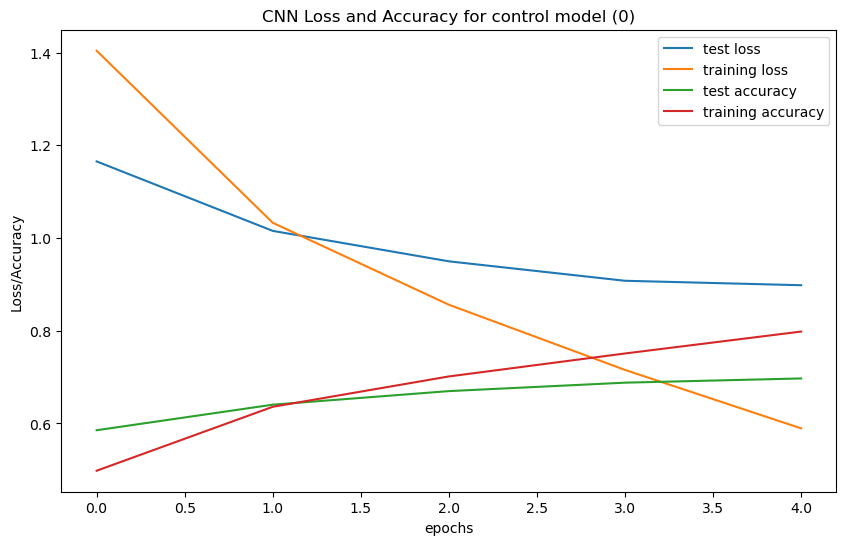

pruning iterations: 100%|██████████| 10/10 [3:42:44<00:00, 1336.41s/it] 


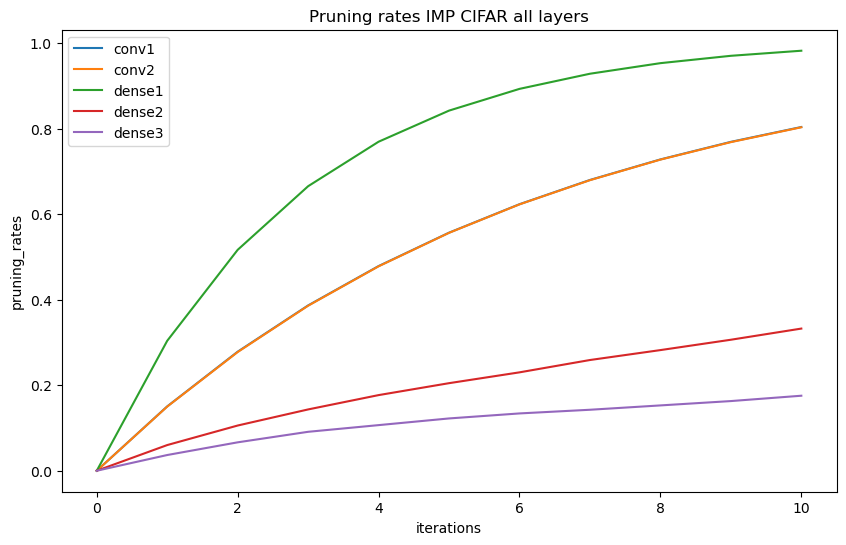

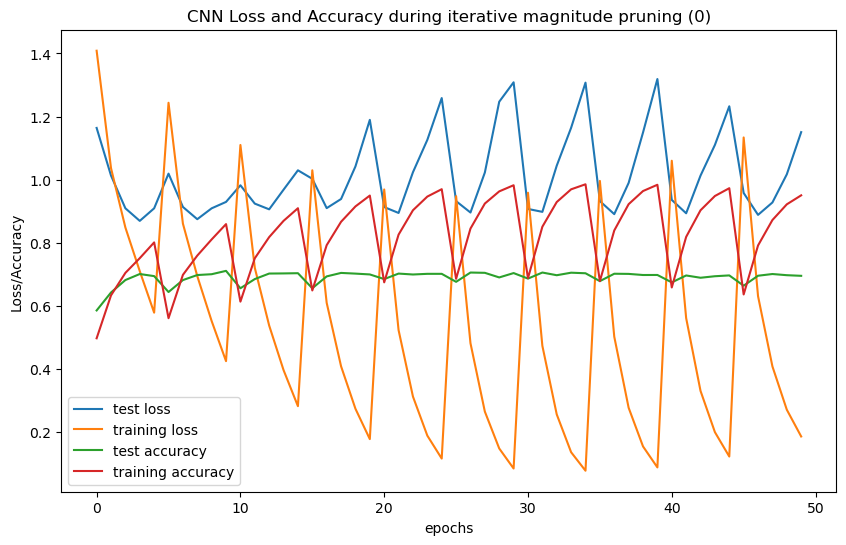

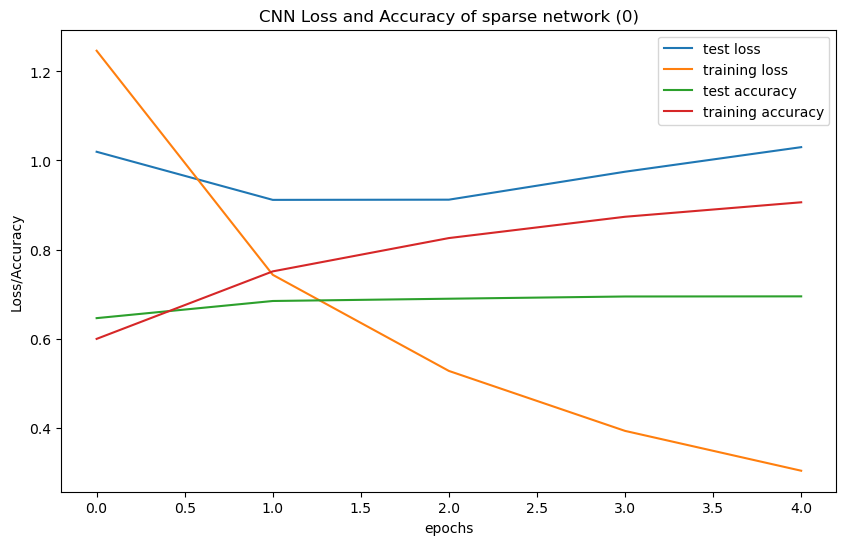

Best accuracy of control model:  0.6971
Best accuracy of sparse model:  0.6948
total pruning rate: 0.9700937455976113
layerwise pruning rates: [0.8038194444444444, 0.0, 0.8031955295138888, 0.0, 0.9822282791137695, 0.0, 0.3324127197265625, 0.0, 0.17539062500000002, 0.0]
It's a winning ticket!


In [7]:
create_lottery_tickets([0], "CIFAR", save_in_between=True)
#create_lottery_tickets(range(10,15), "SVHN")
#create_lottery_tickets(range(10,15), "CINIC")